In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cd /content/drive/My Drive/uygulamam/chestSeg2Unet

/content/drive/My Drive/uygulamam/chestSeg2Unet


## 1.4 Imports

In [41]:
## Imports
import os
import sys
import random

import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
import tensorflow as tf
import tensorflow.keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Conv2DTranspose, Dense, Dropout, Reshape

## Data Generator

In [106]:
class DataSet:
  def __init__(self, images_path = "train/", masks_path = "val/", size = (128,128,3)):
      self.images_path = images_path
      self.masks_path = masks_path
      self.size = size
      self.resize_size = (size[0],size[1])
  
  def loss_func(self, img, pred):
    loss = 0
    for i in range(img.shape[0]):
      for j in range(img.shape[1]):      
          loss += (img[i, j, 0] - pred[i, j, 0]) ** 2
          loss += (img[i, j, 1] - pred[i, j, 1]) ** 2
          loss += (img[i, j, 2] - pred[i, j, 2]) ** 2
    return loss / (img.shape[0] * img.shape[1])
    
  def normalize_images(self, imgs):
      imgs=imgs.astype('float32')
      images=[]      
      for i in range(imgs.shape[0]):
        images.append(imgs[i]/255.0)
      return np.array(images)

  def de_normalize_images(self, imgs):  
      images=[]
      for i in range(imgs.shape[0]):
        img=imgs[i]*255
        images.append(img.astype('uint8'))
      return np.array(images)

  def linear_normalization2D(self, input, min_num=0, max_num=255):
    new=np.zeros((input.shape[0],input.shape[1]),dtype="float32")
    max_pix = np.max(input)
    min_pix = np.min(input)
    pix_diff = max_pix - min_pix
    if pix_diff==0:
      pix_diff=0.01
    new_pix_diff = max_num - min_num

    for i in range(input.shape[0]):
      for j in range(input.shape[1]):
        new[i][j] = (float(input[i][j] - min_pix) / float(pix_diff)) * (new_pix_diff) + min_num

    return new

  def linear_normalization3D(self, input, min_num=0, max_num=255):
    max_pix = np.max(input)
    min_pix = np.min(input)
    pix_diff = max_pix - min_pix
    new_pix_diff = max_num - min_num

    for i in range(input.shape[0]):
      for j in range(input.shape[1]):
        input[i][j][0] = ((input[i][j][0] - min_pix) / pix_diff) * (new_pix_diff) + min_num
        input[i][j][1] = ((input[i][j][1] - min_pix) / pix_diff) * (new_pix_diff) + min_num
        input[i][j][2] = ((input[i][j][2] - min_pix) / pix_diff) * (new_pix_diff) + min_num

    return input

  def plt_draw(self, imgs, row = 1, col = None):
      if col == None:
          col = len(imgs)
      for i in range(len(imgs)):
          plt.subplot(row,col,i+1)
          plt.imshow(imgs[i])
          plt.gray()
          plt.axis('off')
      plt.show()

  def get_dataset(self, max_img=100, validation_split = 0.2, normalize = False):
      images = []
      masks = []

      test_images = []
      test_masks = []

      images_names = os.listdir(self.images_path)
      masks_names = os.listdir(self.masks_path)    
      
      test_num = max_images * validation_split
      train_num = max_images - test_num

      j = 0
      for i in range(len(images_names)):        
          name = images_names[i].split("_")
          mask_name = name[0] + "_mask_" + name[1]
          if masks_names.count(mask_name) > 0:
              img = cv2.resize(cv2.imread(self.images_path + images_names[i]), self.resize_size)
              mask_img = cv2.resize(cv2.imread(self.masks_path + mask_name), self.resize_size)
              if j < train_num:
                images.append(img)
                masks.append(mask_img)
              else:
                test_images.append(img)
                test_masks.append(mask_img)
              j += 1          
          if j == max_img:
              break

      images = np.array(images)
      masks = np.array(masks)
      test_images = np.array(test_images)
      test_masks = np.array(test_masks)

      if normalize == True:        
          images = self.normalize_images(images)
          masks = self.normalize_images(masks)
          test_images = self.normalize_images(test_images)
          test_masks = self.normalize_images(test_masks)

      return images, masks, test_images, test_masks

## UNet Model

In [7]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + (1 - dice_loss(y_true, y_pred))
    
def get_unet_128(input_shape,num_classes=1): #siyah beyaz model
    input_size = input_shape[0]
    
    inputs = Input(shape=input_shape)
    # 128o 7

    down1 = Conv2D(32, (3, 3), padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(32, (3, 3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(64, (3, 3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(64, (3, 3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(128, (3, 3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(128, (3, 3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(256, (3, 3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(256, (3, 3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(512, (3, 3), padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    center = Conv2D(512, (3, 3), padding='same')(center)
    center = BatchNormalization()(center)
    center = Activation('relu')(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(256, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(256, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(256, (3, 3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(128, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(128, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(128, (3, 3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(64, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(64, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(64, (3, 3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(32, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(32, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(32, (3, 3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    # 128

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)    

    model = Model(inputs=inputs, outputs=classify)

    model.compile(optimizer=SGD(lr=0.001),  loss=bce_dice_loss, metrics=["accuracy"])#metrics=[dice_loss]

    return model 

In [61]:
def jaccard_distance(y_true, y_pred):
    smooth=100
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)


def unet(num_classes, input_shape, lr_init, vgg_weight_path=None): #renkli model
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation('relu')(x)

    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation('relu')(x)

    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    for_pretrained_weight = MaxPooling2D()(x)

    # Load pretrained weights.
    if vgg_weight_path is not None:
        vgg16 = Model(img_input, for_pretrained_weight)
        vgg16.load_weights(vgg_weight_path, by_name=True)

    # UP 1
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_4_out])
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # last conv
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)#activation='softmax'
    #x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)#activation='softmax'
    #x = Conv2D(num_classes, (3, 3), activation=None, padding='same')(x)#activation='softmax'
    
    #x = Conv2D(1, (1,1), padding="same", activation="sigmoid")(x)    
    
    model = Model(img_input, x)
    model.compile(optimizer=Adam(lr=lr_init),
                  loss='categorical_crossentropy',#'mean_squared_error',#jaccard_distance,#'categorical_crossentropy',
                  metrics=['accuracy'])#metrics=[dice_coef]
    return model

In [53]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(img_height, img_width, nclasses=3, filters=64):
# down
    input_layer = Input(shape=(img_height, img_width, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    #conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    #conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    #deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    #deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
# output
    output_layer = Conv2D(filters=nclasses, kernel_size=(1, 1))(deconv9)
    output_layer = BatchNormalization()(output_layer)
    #output_layer = Reshape((img_height*img_width, nclasses), input_shape=(img_height, img_width, nclasses))(output_layer)
    output_layer = Activation('softmax')(output_layer)
    
    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model 

In [65]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true /= 255.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def pixelwise_l2_loss(y_true, y_pred):
    y_true /= 255.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    return K.mean(K.square(y_true_f - y_pred_f))

def pixelwise_binary_ce(y_true, y_pred):
    y_true /= 255.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    return K.mean(K.binary_crossentropy(y_true_f, y_pred_f))

def get_unet(img_rows=128, img_cols=128, lr=0.003):
    inputs = Input((img_rows, img_cols, 3))
    conv1 = Conv2D(32, (3, 3), activation=None, padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Conv2D(32, (3, 3), activation=None, padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation=None, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Conv2D(64, (3, 3), activation=None, padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation=None, padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Conv2D(128, (3, 3), activation=None, padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation=None, padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Conv2D(256, (3, 3), activation=None, padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation=None, padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Conv2D(512, (3, 3), activation=None, padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation=None, padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Conv2D(256, (3, 3), activation=None, padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation=None, padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    conv7 = Conv2D(128, (3, 3), activation=None, padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)
    
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation=None, padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    conv8 = Conv2D(64, (3, 3), activation=None, padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Activation('relu')(conv8)
    
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation=None, padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    conv9 = Conv2D(32, (3, 3), activation=None, padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Activation('relu')(conv9)
    
    conv10 = Conv2D(3, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=lr, decay=1e-6), loss=pixelwise_binary_ce, metrics=[dice_coef])

    return model

In [9]:
# y_pred_logit=tf.constant([[-20, -1, 4.5, 12.5, 74, 43.2, -58.4, 8.2, 99.3, -101]])
# y_pred_sigmoid=tf.keras.activations.sigmoid(y_pred_logit)
# y_true=[[5]]
# y_pred=y_pred_sigmoid
# y1=tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred).numpy()
# y2=tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred_logit, from_logits=True).numpy()
# y3=tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred_logit).numpy()
# print(y1, y2, y3)

## Code

In [71]:
images_path = "train/"
masks_path = "val/"
size = (128, 128, 3)
num_classes = 3 #4 aslinda ama 3 rgb nin 3'u imis
max_images = 200
normalize = True#False#
validation_split = 0.2
lr = 0.003

In [107]:
dataset = DataSet(images_path, masks_path, size)
train, masks, test, test_masks = dataset.get_dataset(max_images, validation_split, normalize)

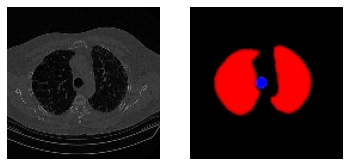

33


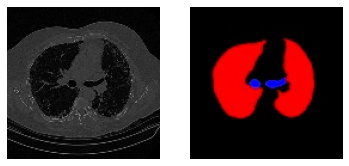

34


In [73]:
id = np.random.randint(0, train.shape[0], 1)[0]
dataset.plt_draw([train[id], masks[id]])
print(id)
id = np.random.randint(0, test.shape[0], 1)[0]
dataset.plt_draw([test[id], test_masks[id]])
print(id)

In [58]:
epochs = 100#200
batch_size = 8
model_save_name = "chestSegUnet"

In [ ]:
#model = get_unet_128(size, num_classes)
#model = unet(num_classes, size, lr)
#model = Unet(size[0],size[1]) # oldu gibi normalize false da
model = get_unet(size[0], size[1], lr)#fena degil normalize true
#model.summary()

## Training the model

In [105]:
model.fit(train, masks, batch_size = batch_size, epochs = epochs, validation_split = validation_split)
#model.save(model_save_name)

Epoch 1/100
16/16 [==============================] - 2s 153ms/step - loss: 0.0021 - dice_coef: 0.0037 - val_loss: 0.0032 - val_dice_coef: 0.0037
Epoch 2/100
16/16 [==============================] - 3s 159ms/step - loss: 0.0021 - dice_coef: 0.0038 - val_loss: 0.0032 - val_dice_coef: 0.0038
Epoch 3/100
16/16 [==============================] - 2s 151ms/step - loss: 0.0020 - dice_coef: 0.0038 - val_loss: 0.0032 - val_dice_coef: 0.0039
Epoch 4/100
16/16 [==============================] - 3s 158ms/step - loss: 0.0020 - dice_coef: 0.0040 - val_loss: 0.0032 - val_dice_coef: 0.0040
Epoch 5/100
16/16 [==============================] - 2s 151ms/step - loss: 0.0020 - dice_coef: 0.0041 - val_loss: 0.0031 - val_dice_coef: 0.0041
Epoch 6/100
16/16 [==============================] - 2s 152ms/step - loss: 0.0020 - dice_coef: 0.0042 - val_loss: 0.0031 - val_dice_coef: 0.0040
Epoch 7/100
16/16 [==============================] - 2s 150ms/step - loss: 0.0020 - dice_coef: 0.0042 - val_loss: 0.0031 - val_dic

## Testing the model

In [ ]:
#from keras.models import load_model
#model = load_model(model_save_name)

loss: 0.24027424097977082


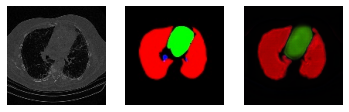

6
loss: 0.24027424097977082


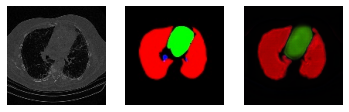

6
loss: 0.21981210761666006


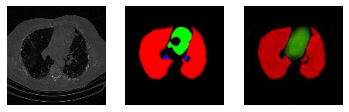

14


In [121]:
for id in np.random.randint(0, test.shape[0], 3):
  #id = np.random.randint(0, test.shape[0], 1)[0]
  pred = model.predict(np.expand_dims(test[id], 0))
  pred = np.reshape(pred, size)
  print("loss: " + str(dataset.loss_func(test_masks[id], pred)))
  #dataset.plt_draw([test[id]])
  #dataset.plt_draw([test_masks[id]])
  #dataset.plt_draw([pred])
  #dataset.plt_draw([dataset.de_normalize_images(pred)])
  #dataset.plt_draw([dataset.olcekleme3b(pred).astype("uint8")])
  dataset.plt_draw([test[id], test_masks[id], dataset.linear_normalization3D(pred).astype("uint8")])
  print(id)

In [ ]:
id = np.random.randint(0, train.shape[0], 1)[0]
pred = model.predict(np.expand_dims(train[id], 0))
pred = np.reshape(pred, size)
print("loss: " + str(dataset.loss_func(masks[id], pred)))
dataset.plt_draw([train[id], masks[id], pred])
print(id)